In [1]:
pip install DeepXDE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf

2024-08-02 11:16:57.415738: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 11:16:58.966677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 11:17:05.206871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [3]:
x_lower = -25
x_upper = 25
t_lower = 0
t_upper = 1

α = 0
β = 0

α_0 = 0
k = 1
ω = 0.88
x_0 = 0
θ_0 = 0
μ = 4 * (k ** 2 - ω)

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [4]:
def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    # Compute the terms for q = ue^(iv)
    q_t_real = u_t * tf.cos(v) - u * v_t * tf.sin(v)
    q_t_imag = u_t * tf.sin(v) + u * v_t * tf.cos(v)

    q_xx_real = u_xx * tf.cos(v) - 2 * u_x * v_x * tf.sin(v) - u * (v_xx * tf.sin(v) + v_x ** 2 * tf.cos(v))
    q_xx_imag = u_xx * tf.sin(v) + 2 * u_x * v_x * tf.cos(v) + u * (v_xx * tf.cos(v) - v_x ** 2 * tf.sin(v))

    q_real = u * tf.cos(v)
    q_imag = u * tf.sin(v)

    abs_q_squared = q_real ** 2 + q_imag ** 2

    nonlinear_term = abs_q_squared * (1 - α * abs_q_squared + β * abs_q_squared ** 2)

    f_real = - q_t_imag + q_xx_real + q_real * nonlinear_term
    f_imag = q_t_real + q_xx_imag + q_imag * nonlinear_term

    return [f_real, f_imag]

In [5]:
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

In [6]:
def init_cond_u(x):
    exp1 = np.exp(np.float128((x[:, 0:1] - x_0) * np.sqrt(μ)))
    exp2 = np.exp(np.float128(2 * (x[:, 0:1] - x_0) * np.sqrt(μ)))

    return np.sqrt(μ * exp1 / (
                ((1 / 2) * exp1 + 1) * ((1 / 2) * exp1 + 1) - (α_0 * μ / 3) * exp2))


def init_cond_v(x):
    return k * x[:, 0:1] + θ_0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [7]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [100] * 2 + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.050937 s



/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-02 11:17:58.377800: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-02 11:17:58.377851: I tens

'compile' took 1.120459 s



2024-08-02 11:17:59.287789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2024-08-02 11:17:59.633792: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5fa0019050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 11:17:59.633841: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-02 11:17:59.888039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 11:18:01.182835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-08-02 11:18:04.936450: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_4', 776 bytes spill stores, 1252 bytes spill loads

2024-08-02 11:18:05.116301: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once fo

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [7.25e-02, 7.44e-03, 1.93e-03, 4.16e-04, 1.23e+00, 4.96e-04, 2.71e-01, 2.64e+02]    [7.25e-02, 7.44e-03, 1.93e-03, 4.16e-04, 1.23e+00, 4.96e-04, 2.71e-01, 2.64e+02]    []  
1000      [1.92e-02, 1.89e-02, 3.32e-05, 1.37e-04, 6.93e-01, 2.37e-02, 1.46e-02, 1.16e+01]    [1.92e-02, 1.89e-02, 3.32e-05, 1.37e-04, 6.93e-01, 2.37e-02, 1.46e-02, 1.16e+01]    []  
2000      [2.51e-02, 2.45e-02, 6.55e-06, 2.12e-04, 7.80e-01, 3.78e-02, 1.62e-02, 2.93e+00]    [2.51e-02, 2.45e-02, 6.55e-06, 2.12e-04, 7.80e-01, 3.78e-02, 1.62e-02, 2.93e+00]    []  
3000      [7.66e-03, 8.35e-03, 3.69e-05, 1.09e-04, 4.38e-02, 5.68e-03, 1.67e-02, 1.71e-01]    [7.66e-03, 8.35e-03, 3.69e-05, 1.09e-04, 4.38e-02, 5.68e-03, 1.67e-02, 1.71e-01]    []  
4000      [7.86e-03, 7.07e-03, 3.93e-05, 5.87e-05, 1.85e-02, 1.23e-04, 1.73e-0

2024-08-02 11:19:00.911495: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [1.85e-03, 1.86e-03, 7.34e-06, 3.61e-06, 3.77e-04, 3.12e-04, 7.77e-03, 2.78e-03]    [1.85e-03, 1.86e-03, 7.34e-06, 3.61e-06, 3.77e-04, 3.12e-04, 7.77e-03, 2.78e-03]    []  


2024-08-02 11:19:05.605032: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_37', 676 bytes spill stores, 752 bytes spill loads



11000     [9.85e-04, 1.43e-03, 4.51e-06, 1.73e-05, 2.08e-04, 1.65e-05, 3.62e-03, 6.02e-04]    [9.85e-04, 1.43e-03, 4.51e-06, 1.73e-05, 2.08e-04, 1.65e-05, 3.62e-03, 6.02e-04]        
12000     [6.10e-04, 5.86e-04, 1.31e-06, 4.61e-06, 1.58e-04, 9.33e-06, 1.54e-03, 2.09e-04]    [6.10e-04, 5.86e-04, 1.31e-06, 4.61e-06, 1.58e-04, 9.33e-06, 1.54e-03, 2.09e-04]        
13000     [3.78e-04, 3.29e-04, 2.84e-07, 9.66e-07, 1.20e-04, 5.42e-06, 9.23e-04, 1.10e-04]    [3.78e-04, 3.29e-04, 2.84e-07, 9.66e-07, 1.20e-04, 5.42e-06, 9.23e-04, 1.10e-04]        
14000     [2.63e-04, 2.85e-04, 6.61e-07, 5.64e-07, 9.57e-05, 3.00e-06, 3.01e-04, 8.14e-05]    [2.63e-04, 2.85e-04, 6.61e-07, 5.64e-07, 9.57e-05, 3.00e-06, 3.01e-04, 8.14e-05]        
15000     [1.66e-04, 1.39e-04, 6.49e-07, 7.17e-07, 6.84e-05, 2.20e-06, 1.49e-04, 6.82e-05]    [1.66e-04, 1.39e-04, 6.49e-07, 7.17e-07, 6.84e-05, 2.20e-06, 1.49e-04, 6.82e-05]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_O

(<deepxde.model.LossHistory at 0x7f60e5d654e0>,
 <deepxde.model.TrainState at 0x7f60e5d65330>)

In [8]:
prediction = model.predict(X_star)
u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q_real = u * np.cos(v)
q_imag = u * np.sin(v)

u = q_real
v = q_imag

q = np.sqrt(u ** 2 + v ** 2)

In [9]:
def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def q_exact(x, t):
    return np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))

In [10]:
data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-25.000000,0.0,-0.000010,-0.000002,0.000010,0.000119,0.000016,0.000120
1,-24.803922,0.0,0.000024,0.000008,0.000026,0.000122,0.000042,0.000129
2,-24.607843,0.0,0.000033,0.000018,0.000037,0.000119,0.000069,0.000138
3,-24.411765,0.0,0.000026,0.000022,0.000034,0.000111,0.000097,0.000147
4,-24.215686,0.0,0.000014,0.000017,0.000022,0.000096,0.000125,0.000158
...,...,...,...,...,...,...,...,...
51451,24.215686,1.0,0.000204,-0.000197,0.000284,-0.000141,-0.000614,0.000630
51452,24.411765,1.0,0.000084,-0.000146,0.000169,-0.000018,-0.000588,0.000589
51453,24.607843,1.0,-0.000007,0.000024,0.000025,0.000091,-0.000543,0.000550
51454,24.803922,1.0,-0.000005,0.000309,0.000310,0.000182,-0.000481,0.000514


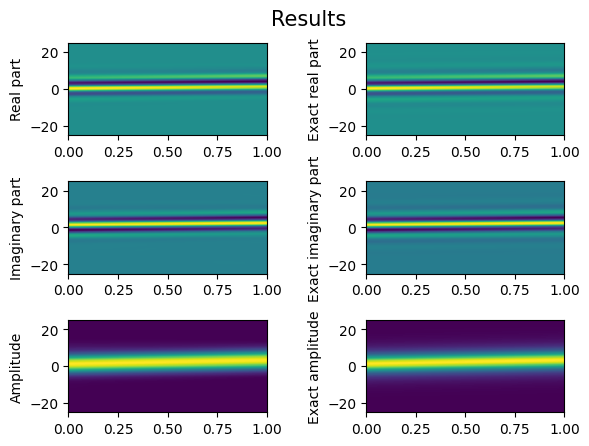

In [11]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()